In [1]:
import numpy as np
import scipy as sp
import scipy.ndimage as ndimage
import random

import pollution

import matplotlib.pyplot as plt
import matplotlib
from tqdm import trange
import tqdm
import os
import imageio.v2 as imageio
import math
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import networkx as nx
import os
import math
import matplotlib.ticker as mtick
import ipywidgets as widgets
from scipy.optimize import minimize_scalar, minimize
from matplotlib.lines import Line2D
# import moviepy.editor as mp

font = {        'size'   : 20}
mpl.rc('font', **font)
params = {'figure.figsize': (10, 5),
          'font.family':'sans-serif',
          'font.sans-serif':'Nimbus Sans'}#,
#           'font.family':'sans-serif',
#           'font.sans-serif':'HelveticaNeueMedium'}
matplotlib.rcParams.update(params)
# %matplotlib notebook

In [3]:
mu=np.arange(0,1.05,0.05)
D=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
L = 50
A = math.pi*(5**2)
runs=200
folder = 'Data/Imitation/'
N = [20,50,80]
pcp = np.loadtxt(folder+'pcp_all.csv').reshape(len(N),len(D),len(mu),runs)
cc = np.loadtxt(folder+'cc_all.csv').reshape(len(N),len(D),len(mu),runs)
c_rate = np.loadtxt(folder+'c_rate_all.csv').reshape(len(N),len(D),len(mu),runs)

font = {        'size'   : 20}
params = {'legend.fontsize': 'medium',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'medium',
         'axes.titlesize':'large',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
mpl.rc('font', **font)
plt.rcParams.update(params)

D_corners = np.array([0]+D)+0.05
mu_corners = np.diff(np.array([-0.05]+list(mu)+[1.05]))/2 + np.arange(-0.05,1.05,0.05)
mu_mesh,D_mesh = np.meshgrid(mu_corners,D_corners)
mu_grid,D_grid = np.meshgrid(mu,D)

See DYNAMICS OF OPINION POLARIZATION Biondi et al 2022 for references on polarization metrics

https://arxiv.org/pdf/2206.06134.pdf

By their results: $GDI \sim P_1$, $P_2 \sim P_3$, $P_1 \geq P_3 - \frac{P_4^2}{| \mathcal{V} |}$

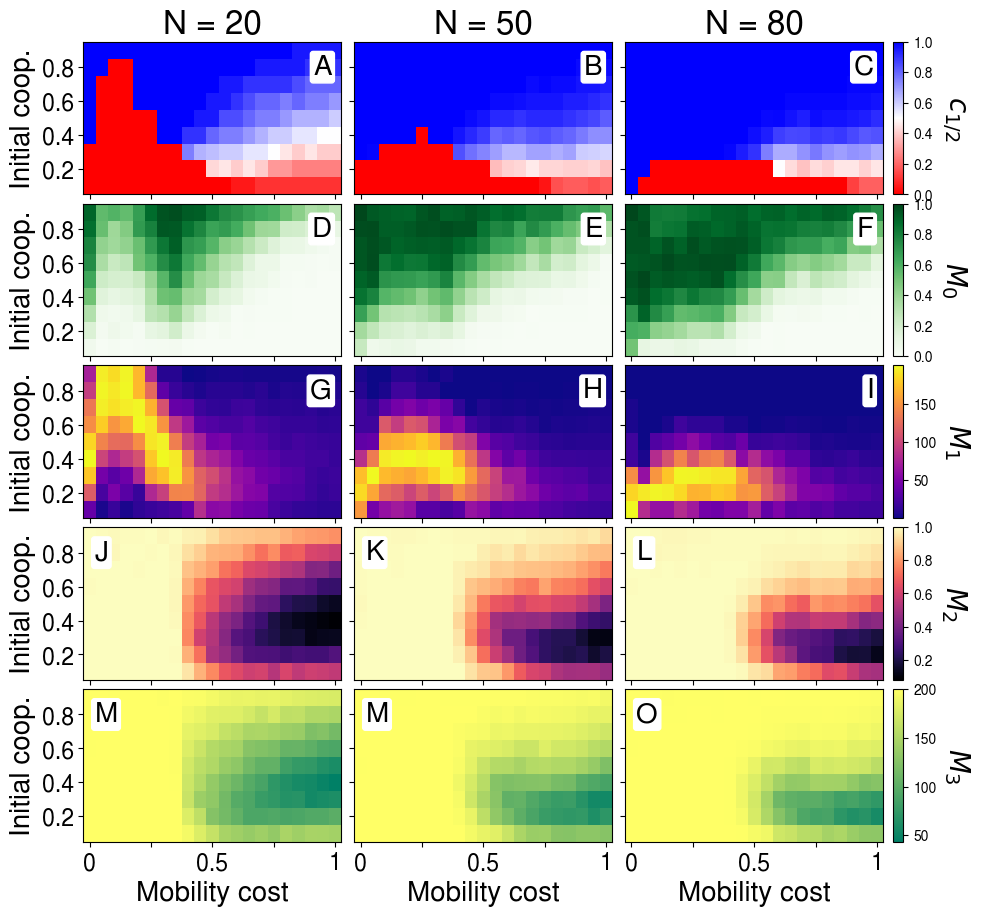

In [49]:
c_norm = c_rate*2-1 # normalise to [-1,1]
c_mean = c_norm.mean(axis=-1)
P1 = np.sum((c_norm-c_mean.reshape((len(N),len(D),len(mu),1)))**2,axis=-1)
P2 = (c_norm**2).mean(axis=-1)
P3 = (c_norm**2).sum(axis=-1)
P4 = np.abs(c_norm).sum(axis=-1)
c_med = np.median(c_norm,axis=-1)
mass_c_no = (c_norm==1).sum(axis=-1)/c_norm.shape[-1]

metrics = [np.median(c_rate,axis=-1),mass_c_no,P1,P2,P4]
c_labels = [r'$c_{1/2}$','$M_0$','$M_1$','$M_2$','$M_3$']
cmaps = ['bwr_r','Greens','plasma','magma','summer']
vmins = [m.min() for m in metrics]
vmaxs = [m.max() for m in metrics]
vmins[0:2]=[0]*2
vmaxs[0:2]=[1]*2

fig,axs=plt.subplots(figsize=(10,10),ncols=3,nrows=len(metrics),
                     sharex=True,sharey=True)
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.05,
                    hspace=0.06)

ims=[0]*len(metrics)
for i in range(3):
    axs[0,i].set_title(f"N = {N[i]}",size='large')
    axs[-1,i].set_xticks([0,0.25,0.5,0.75,1])
    axs[-1,i].set_xticklabels([0,'',0.5,'',1])
    axs[-1,i].set_xlabel('Mobility cost')
    for j in range(len(metrics)):
        ims[j]=axs[j,i].pcolormesh(mu_mesh,1-D_mesh,metrics[j][i],
                               cmap=cmaps[j],vmin=vmins[j],vmax=vmaxs[j])

cb=[0]*axs.shape[0]
letters=['A','B','C',
         'D','E','F',
         'G','H','I',
         'J','K','L',
         'M','M','O']
for j in range(axs.shape[0]):
#     axs[j,2].set_visible(False)
    pos = axs[j,-1].get_position()
    cax = fig.add_axes([pos.xmax+0.01,pos.ymin,
                       0.01,pos.ymax-pos.ymin])    
    cb[j]=fig.colorbar(ims[j],cax=cax)
    cb[j].set_label(label=c_labels[j],rotation=-90,va='center',ha='center',labelpad=15)
    cb[j].ax.tick_params(labelsize=10)
    axs[j,0].set_yticks([0.2,0.4,0.6,0.8])
    axs[j,0].set_yticklabels([0.2,0.4,0.6,0.8])
    axs[j,0].set_ylabel('Initial coop.')
for j in range(3):
    for i in range(3):
        axs[i,j].text(0.985,0.8,letters[i*3+j],va='center',ha='right',
                      bbox=dict(boxstyle='round', fc="w",pad=0.1,ec='w'))
    for i in range(3,5):
        axs[i,j].text(0.02,0.8,letters[i*3+j],va='center',ha='left',
                      bbox=dict(boxstyle='round', fc="w",pad=0.1,ec='w'))

# ax_outer=fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
# # plt.xlabel("common X",fontsize='medium')
# plt.ylabel(r"Initial cooperators",size='large')
# plt.xlabel("Mobility cost",size='large')
# fig.tight_layout()
fig.savefig("Figures/Imitation/c_norm_metrics.png",bbox_inches='tight')
fig.savefig("Figures/Imitation/c_norm_metrics.eps",format='eps',bbox_inches='tight')

In [37]:
print(letters[5+2])

H


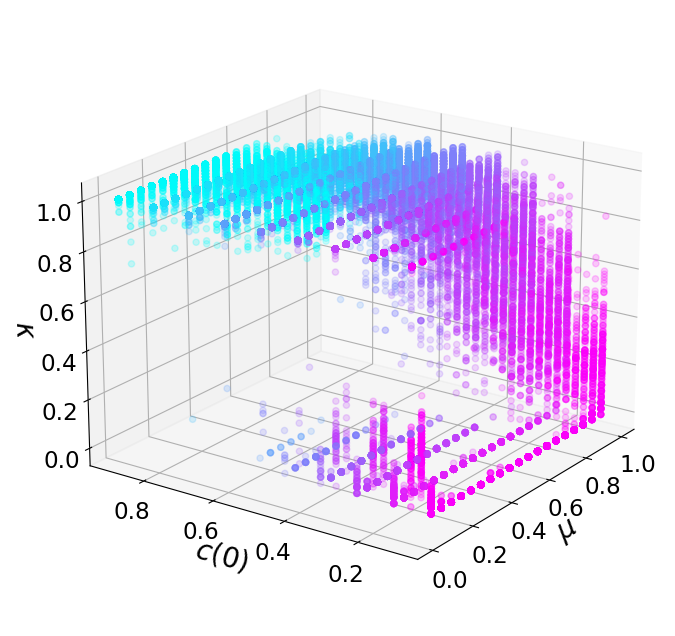

In [21]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
x=mu_grid.ravel()
y=1-D_grid.ravel()
z=np.zeros_like(x)

for j in range(3):
    ax.clear()
    for i in range(200):
        z=cc[j,:,:,i].ravel()
        ax.scatter(x,y,z,c=y,alpha=0.2,cmap='cool_r')

    ax.set_xlabel("$\mu$")
    ax.set_ylabel("$c(0)$")
    ax.view_init(20,-145)
    ax.set_zlabel("$\kappa$",rotation=0)
#     ax.set_title(f"$N =${N[j]}")
    fig.savefig(f"Figures/Imitation/N{N[j]}_kappa_3d_scatter.png",bbox_inches='tight')
# ax.plot_surface(mu_grid,D_grid,np.mean(c_rate[0],axis=-1),cmap='seismic_r')
# ax.plot_surface(mu_grid,D_grid,np.sum((c_rate[0]-0.5)**2/200,axis=-1),cmap='seismic_r')
# ax.contour(mu_grid,D_grid,c_rate[0].mean(axis=-1),cmap='seismic_r')

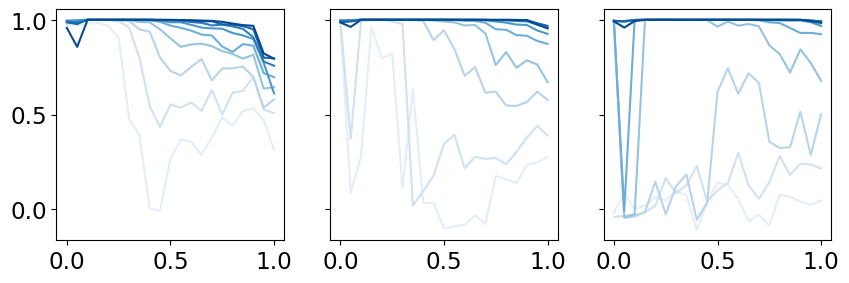

In [69]:
fig,axs=plt.subplots(figsize=(10,3),ncols=3,sharex=True,sharey=True)
cols = matplotlib.cm.get_cmap('Blues_r')
for i in range(3):
    for j in range(9):
        im=axs[i].plot(mu, [np.corrcoef(cc[i,j,k],
                                     c_rate[i,j,k])[0,1] 
                         for k in range(len(mu))],
                    c=cols(1-D[j]))
# plt.colorbar(cmap='Blues_r')

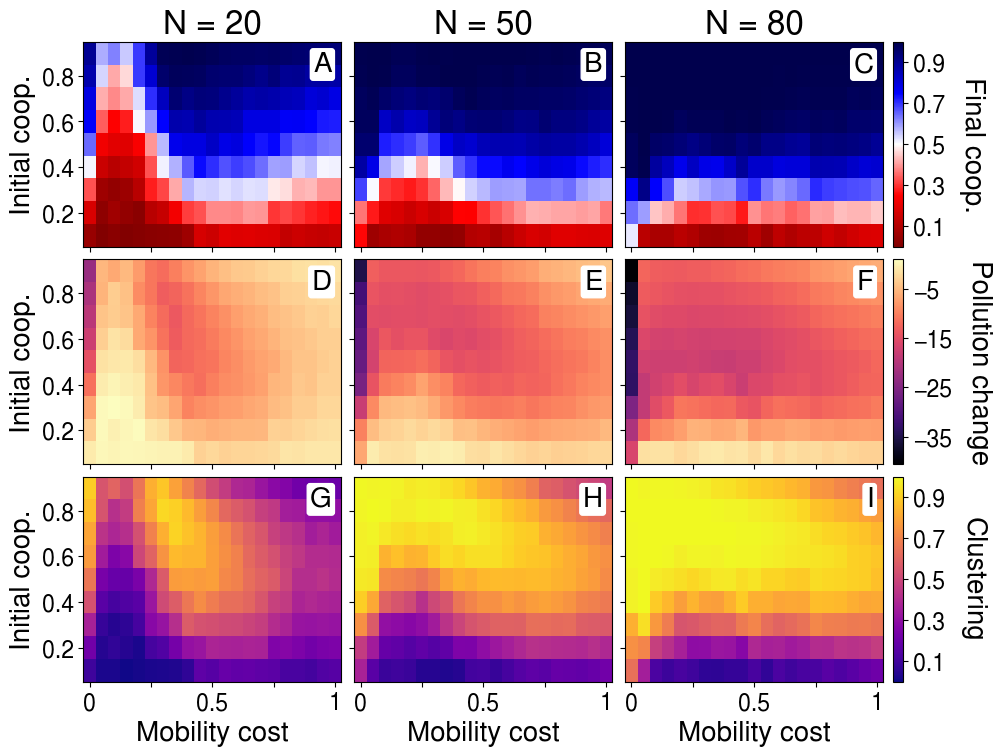

In [57]:
fig,axs=plt.subplots(nrows=3,ncols=3,sharex=True,sharey=True,figsize=(10,8))
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.05,
                    hspace=0.06)
c_rate_lims = [np.min(c_rate.mean(axis=-1)),np.max(c_rate.mean(axis=-1))]
cc_lims = [np.min(cc.mean(axis=-1)),np.max(cc.mean(axis=-1))]
pcp_lims = [np.min(pcp[:,:,:,:].mean(axis=-1)),np.max(pcp.mean(axis=-1))]

ims=[0,0,0]
for i in range(3):
    axs[0,i].set_title(f"N = {N[i]}",size='large')
    ims[0]=axs[0,i].pcolormesh(mu_mesh,1-D_mesh,np.mean(c_rate[i],axis=-1),
                        cmap='seismic_r',vmin=0,vmax=1)
    ims[1]=axs[1,i].pcolormesh(mu_mesh,1-D_mesh,np.mean(pcp[i],axis=-1),
                        cmap='magma',vmin=pcp_lims[0],vmax=pcp_lims[1])
    ims[2]=axs[2,i].pcolormesh(mu_mesh,1-D_mesh,np.mean(cc[i],axis=-1),vmin=0,vmax=1,cmap='plasma')
    
    axs[2,i].set_xticks([0,0.25,0.5,0.75,1])
    axs[2,i].set_xticklabels([0,'',0.5,'',1])
    axs[i,0].set_yticks([0.2,0.4,0.6,0.8])
    axs[i,0].set_yticklabels([0.2,0.4,0.6,0.8])
    
cb=[0,0,0]
# c_labels=[r'$\bar{c}(T)$',r'$\bar{\Delta}\hat{P}$',r'$\bar{\kappa}$']
c_labels=['Final coop.','Pollution change','Clustering']
letters=['A','B','C','D','E','F','G','H','I']
ctick_vals=[np.arange(0.1,1,0.2),np.arange(-35,0,10),np.arange(0.1,1,0.2)]
for j in range(3):
#     axs[j,2].set_visible(False)
    pos = axs[j,-1].get_position()
    cax = fig.add_axes([pos.xmax+0.01,pos.ymin,
                       0.01,pos.ymax-pos.ymin])    
    cb[j]=fig.colorbar(ims[j],cax=cax,ticks=ctick_vals[j])
    cb[j].set_label(label=c_labels[j],rotation=-90,va='bottom',ha='center',labelpad=10)
#     cb[j].ax.tick_params(labelsize=10)
    
    axs[j,0].set_yticks([0.2,0.4,0.6,0.8])
    axs[j,0].set_yticklabels([0.2,0.4,0.6,0.8])
    axs[j,0].set_ylabel("Initial coop.")
    axs[-1,j].set_xlabel("Mobility cost")
    for i in range(3):
        axs[i,j].text(0.985,0.85,letters[i*3+j],va='center',ha='right',
                      bbox=dict(boxstyle='round', fc="w",pad=0.1,ec='w'))
    
ax_outer=fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
# plt.xlabel("common X",fontsize='medium')
# plt.ylabel(r"Initial coop.")#,size='large')
# plt.xlabel("Mobility cost")#,size='large')
fig.savefig("Figures/Imitation/single_cost.png",bbox_inches='tight')
fig.savefig("Figures/Imitation/single_cost.eps",format='eps',bbox_inches='tight')

In [54]:
print(np.arange(0.1,1,0.2))

[0.1 0.3 0.5 0.7 0.9]
